In [3]:
import os
import math
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from pyproj import CRS
from shapely import box
from pyproj import CRS
from matplotlib.patches import Rectangle

import autoroot
from rs_tools._src.geoprocessing.goes.reproject import add_goes16_crs
from rs_tools._src.geoprocessing.msg.reproject import add_msg_crs
from rs_tools._src.geoprocessing.interp import resample_rioxarray

%load_ext autoreload
%autoreload 2

/opt/conda/envs/rs_tools/lib/python3.11/site-packages/goes2go/data.py:519: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  within=pd.to_timedelta(config["nearesttime"].get("within", "1H")),
/opt/conda/envs/rs_tools/lib/python3.11/site-packages/goes2go/NEW.py:188: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  within=pd.to_timedelta(config["nearesttime"].get("within", "1H")),


Validation Metrics:

- <del> Histograms (global, shared FOV) </del>
- Power Spectrum (global, shared FOV)
- <del> SSIM (shared FOV) </del> 
- <del> MSE, MAE, etc. (shared FOV) </del>

- <del> Metrics per band </del> 
- Metrics for cloudy vs. not
- Metrics for land vs. ocean

In [4]:
goes_band = 14 # IR 12.3 um
msg_band = 5 # IR 12 um

In [5]:
goes_path = '/mnt/disks/goes-data/goes/'
msg_path = '/mnt/disks/msg-data/msg/'

In [6]:
msg_files = [os.path.join(msg_path, f) for f in os.listdir(msg_path) if f.endswith('.nc')]
msg_files.sort()
msg_file = msg_files[1]
print(msg_file)

goes_files = [os.path.join(goes_path, f) for f in os.listdir(goes_path) if f.endswith('.nc')]
goes_files.sort()
goes_file = goes_files[0]
print(goes_file)

/mnt/disks/msg-data/msg/20200101005743_msg.nc
/mnt/disks/goes-data/goes/20200101010021_goes16.nc


In [7]:
msg_ds = xr.open_dataset(msg_file)
goes_ds = xr.open_dataset(goes_file)

In [8]:
# Move specific coordinate variables to data variables
goes_ds = goes_ds.reset_coords(["cloud_mask"])
goes_ds = goes_ds.drop_vars(["latitude", "longitude"])

goes_ds = add_goes16_crs(goes_ds)

goes_ds.rio.set_spatial_dims(
    x_dim="x",
    y_dim="y",
    inplace=True,
).rio.write_coordinate_system(inplace=True);

In [9]:
# Move specific coordinate variables to data variables
msg_ds = msg_ds.reset_coords(["cloud_mask"])
msg_ds = msg_ds.drop_vars(["latitude", "longitude"])

msg_ds = add_msg_crs(msg_ds)

msg_ds.rio.set_spatial_dims(
    x_dim="x",
    y_dim="y",
    inplace=True,
).rio.write_coordinate_system(inplace=True);

## Reproject GOES/MSG

In [10]:
msg_ds = add_msg_crs(msg_ds)
goes_ds = add_goes16_crs(goes_ds)

In [11]:
def meters_to_degrees(resolution_in_meters, latitude):
    # Convert latitude resolution
    resolution_in_degrees_lat = resolution_in_meters / 111000
    
    # Convert longitude resolution
    resolution_in_degrees_lon = resolution_in_meters / (111000 * math.cos(math.radians(latitude)))
    
    return resolution_in_degrees_lat, resolution_in_degrees_lon

# Example usage
resolution_in_meters = 3_000.4  # 5 kilometers
latitude = 0  # Example latitude

resolution_in_degrees = meters_to_degrees(resolution_in_meters, latitude)
resolution_in_degrees

(0.02703063063063063, 0.02703063063063063)

In [12]:
dst_crs = CRS.from_epsg(4326)  # WGS 84
dst_resolution = 0.027 # in your destination units, in this case degrees

In [13]:
goes_ds_reproject = goes_ds.rio.reproject(dst_crs=dst_crs, resolution=dst_resolution)
msg_ds_reproject = msg_ds.rio.reproject(dst_crs=dst_crs, resolution=dst_resolution)

(-180.0, 80.0)

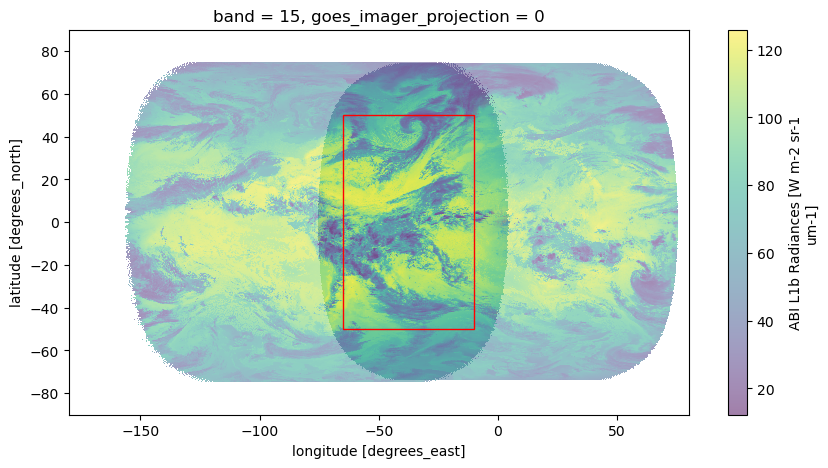

In [29]:
plt.figure(figsize=(10, 5))
msg_ds_reproject.Rad.isel(band=msg_band).plot(alpha=0.5, add_colorbar=False)
goes_ds_reproject.Rad.isel(band=goes_band).plot(alpha=0.5, add_colorbar=True)

# Draw bounding box
# Get the current reference
ax = plt.gca()
# Create a Rectangle patch around [-60, -60.5, -15, 60]
rect = Rectangle((-65, -50), 55, 100, linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.ylim(-90, 90)
plt.xlim(-180, 80)

#### Clip to common field-of-view

In [16]:
# Extract the bounding boxes of the two datasets
bbox1 = box(*msg_ds_reproject.rio.bounds())
bbox2 = box(*goes_ds_reproject.rio.bounds())

# Find the intersection of the two bounding boxes
intersection_bbox = bbox1.intersection(bbox2)

In [17]:
out = goes_ds_reproject.rio.clip_box(*intersection_bbox.bounds, crs=msg_ds_reproject.rio.crs)
out

<xarray.Dataset> Size: 1GB
Dimensions:                 (x: 3236, y: 5491, band: 16)
Coordinates:
  * x                       (x) float64 26kB -81.27 -81.24 ... 6.049 6.076
  * y                       (y) float64 44kB 74.17 74.14 74.12 ... -74.03 -74.06
  * band                    (band) int64 128B 1 2 3 4 5 6 ... 11 12 13 14 15 16
    goes_imager_projection  int64 8B 0
Data variables:
    Rad                     (band, y, x) float32 1GB 0.05076 0.05076 ... nan nan
    cloud_mask              (y, x) float64 142MB 0.0 0.0 0.0 0.0 ... nan nan nan
Attributes: (12/30)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    production_site:           WCDAS
    ...                        ...
    timeline_id:               ABI Mode 6
    date_created:              2020-01-01T01:09:58.1Z
    time_coverage_start:       2020-01-01T01:00:21.6Z
    time_coverage_end:         2020-01-01T01:09:52.4Z
    LUT_Filenames:             SpaceLookParams(FM1A_CDRL79RevP_PR_08_01_01)-6...
    id:                        438b4b74-5233-47d6-8a77-af5ca15f3a0b

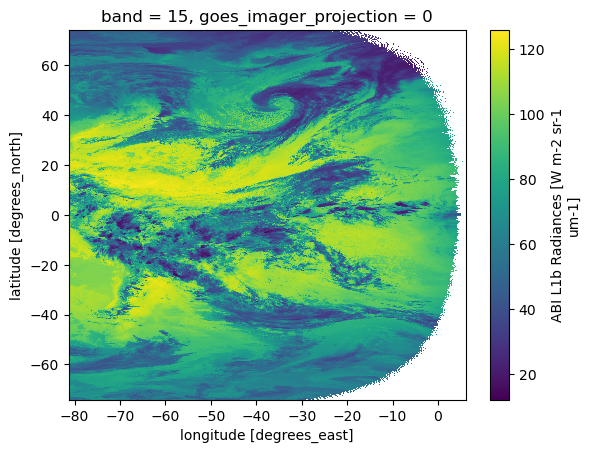

In [15]:
out.Rad.isel(band=goes_band).plot()

#### Clip to limited field-of-view

In [18]:
bounds = out.rio.bounds()
bounds_clipped = [-65, -50.5, -10, 50]

In [20]:
bbox = box(*bounds_clipped)

In [21]:
out_clipped = out.rio.clip_box(*bbox.bounds)
msg_clipped = msg_ds_reproject.rio.clip_box(*bbox.bounds)

(-50.0, 50.0)

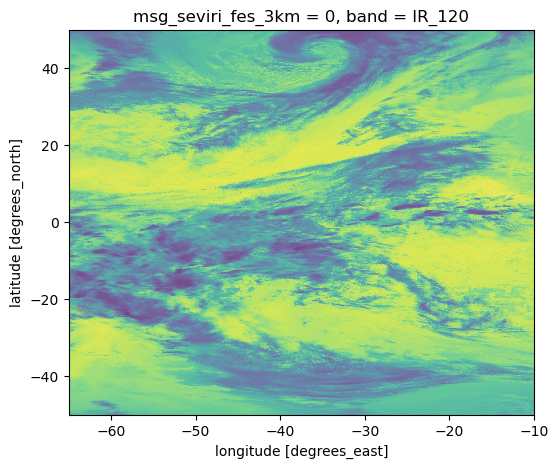

In [49]:
plt.figure(figsize=(6, 5))
out_clipped.Rad.isel(band=goes_band).plot(alpha=0.5, add_colorbar=False)
msg_clipped.Rad.isel(band=msg_band).plot(alpha=0.5, add_colorbar=False)
plt.xlim(-65, -10)
plt.ylim(-50, 50)

### Metrics development 

- Test for different resampling resolutions

### Histograms

- Test histograms for different bin sizes
    - Why do we see spikes in the GOES histograms?

Text(0.5, 1.0, 'Histograms of MSG and GOES IR data (WGS 84)')

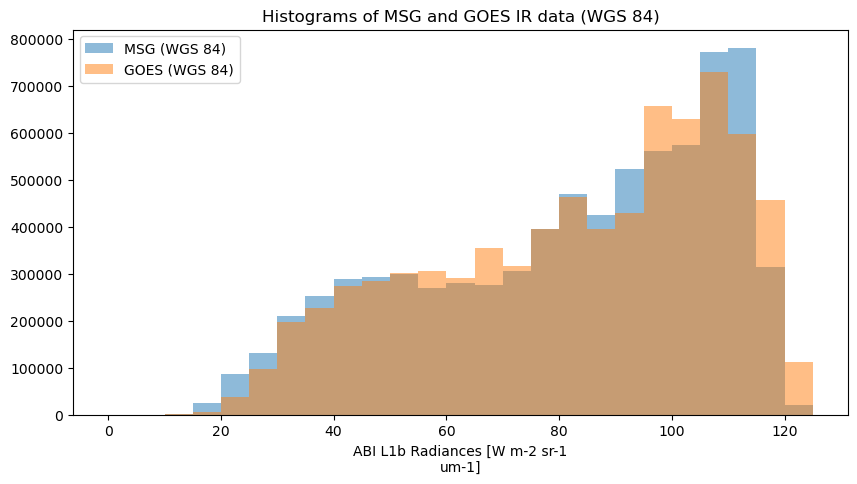

In [35]:
# Histograms
bins = np.arange(0, 130, 5)

plt.figure(figsize=(10, 5))
msg_clipped.Rad.isel(band=msg_band).plot.hist(bins=bins, alpha=0.5, label='MSG (WGS 84)')
out_clipped.Rad.isel(band=goes_band).plot.hist(bins=bins, alpha=0.5, label='GOES (WGS 84)')
plt.legend()
plt.title('Histograms of MSG and GOES IR data (WGS 84)')

Text(0.5, 1.0, 'Histograms of MSG and GOES IR data (native CRS)')

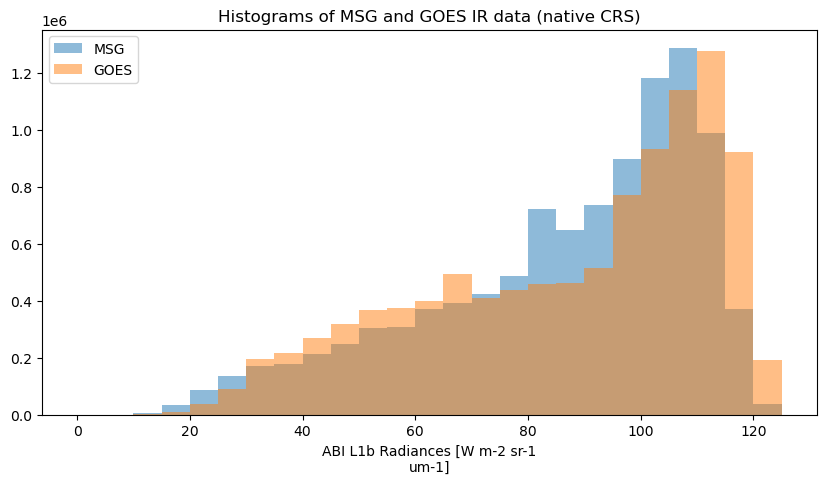

In [36]:
# Histograms
bins = np.arange(0, 130, 5)

plt.figure(figsize=(10, 5))
msg_ds.Rad.isel(band=msg_band).plot.hist(bins=bins, alpha=0.5, label='MSG')
goes_ds.Rad.isel(band=goes_band).plot.hist(bins=bins, alpha=0.5, label='GOES')
plt.legend()
plt.title('Histograms of MSG and GOES IR data (native CRS)')

### MSE, MAE, RMSE

- Make sure that the sizes are the exact same

In [44]:
def mse(x, y):
    return np.mean((x - y)**2)
def mae(x, y):
    return np.mean(np.abs(x - y))
def rmse(x, y):
    return np.sqrt(mse(x, y))

In [50]:
mse(msg_clipped.Rad.isel(band=msg_band).values, out_clipped.Rad.isel(band=goes_band).values)

210.2202

In [51]:
mae(msg_clipped.Rad.isel(band=msg_band).values, out_clipped.Rad.isel(band=goes_band).values)

10.140139

In [52]:
rmse(msg_clipped.Rad.isel(band=msg_band).values, out_clipped.Rad.isel(band=goes_band).values)

14.498972

### Structural Similarity Index Measure

In [53]:
from skimage.metrics import structural_similarity as ssim

In [54]:
from skimage.metrics import structural_similarity as ssim

# Calculate the data range for the images
data_range = max(msg_clipped.Rad.max().values, out_clipped.Rad.max().values) - min(msg_clipped.Rad.min().values, out_clipped.Rad.min().values)

# Compute SSIM with the data_range parameter
ssim_value = ssim(
    msg_clipped.Rad.isel(band=msg_band).values,
    out_clipped.Rad.isel(band=goes_band).values,
    data_range=data_range
)

print(f"SSIM: {ssim_value}")

SSIM: 0.5522607997540675


#### Cloudmask Selection

In [77]:
goes_data_clear = out_clipped.Rad.where(out_clipped.cloud_mask == 0)
goes_data_cloudy = out_clipped.Rad.where(out_clipped.cloud_mask > 0)

# NOTE: MSG data has 4 cloud classes {0, 1, 2, 3}

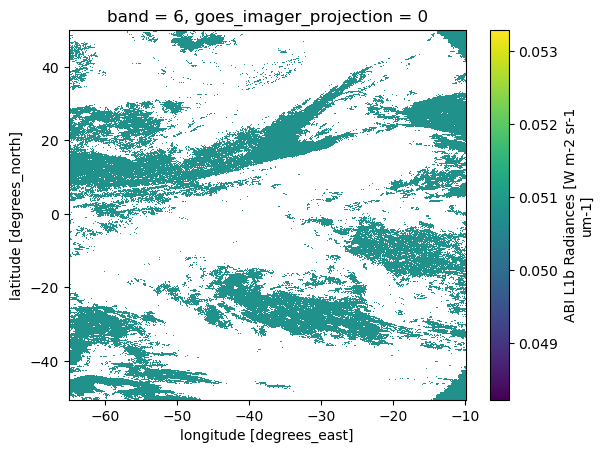

In [78]:
goes_data_clear.isel(band=msg_band).plot()

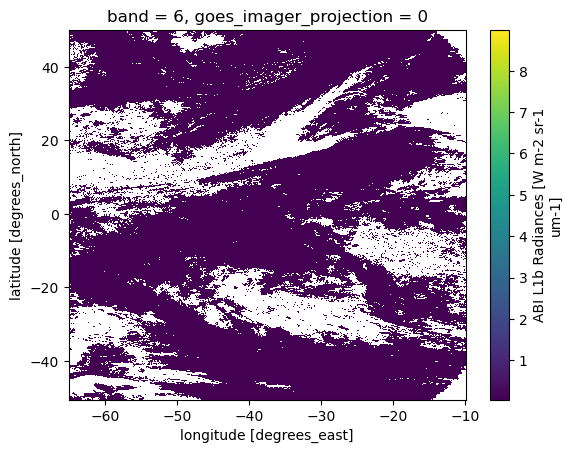

In [79]:
goes_data_cloudy.isel(band=msg_band).plot()

#### Land vs. Ocean Selection

In [22]:
from global_land_mask import globe

In [28]:
out_clipped

<xarray.Dataset> Size: 546MB
Dimensions:                 (x: 2038, y: 3723, band: 16)
Coordinates:
  * x                       (x) float64 16kB -64.99 -64.96 ... -10.02 -9.989
  * y                       (y) float64 30kB 50.0 49.98 49.95 ... -50.46 -50.49
  * band                    (band) int64 128B 1 2 3 4 5 6 ... 11 12 13 14 15 16
    goes_imager_projection  int64 8B 0
Data variables:
    Rad                     (band, y, x) float32 486MB 0.05076 0.05076 ... 60.96
    cloud_mask              (y, x) float64 61MB 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0
Attributes: (12/30)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    production_site:           WCDAS
    ...                        ...
    timeline_id:               ABI Mode 6
    date_created:              2020-01-01T01:09:58.1Z
    time_coverage_start:       2020-01-01T01:00:21.6Z
    time_coverage_end:         2020-01-01T01:09:52.4Z
    LUT_Filenames:             SpaceLookParams(FM1A_CDRL79RevP_PR_08_01_01)-6...
    id:                        438b4b74-5233-47d6-8a77-af5ca15f3a0b

In [40]:
latitudes = out_clipped.x.values
longitudes = out_clipped.y.values

# Create a 2D grid of coordinates
lat_grid, lon_grid = np.meshgrid(latitudes, longitudes)

In [41]:
land_mask = globe.is_land(lat_grid, lon_grid)

In [42]:
land_mask.shape

(3723, 2038)

In [44]:
goes_land = out_clipped.Rad.where(land_mask)
goes_water = out_clipped.Rad.where(~land_mask)

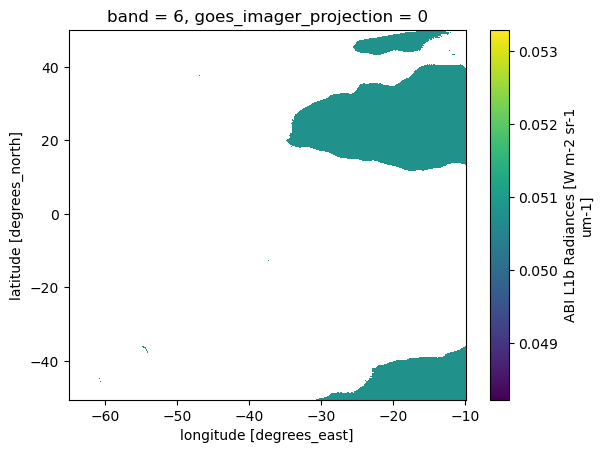

In [45]:
goes_land.isel(band=msg_band).plot()

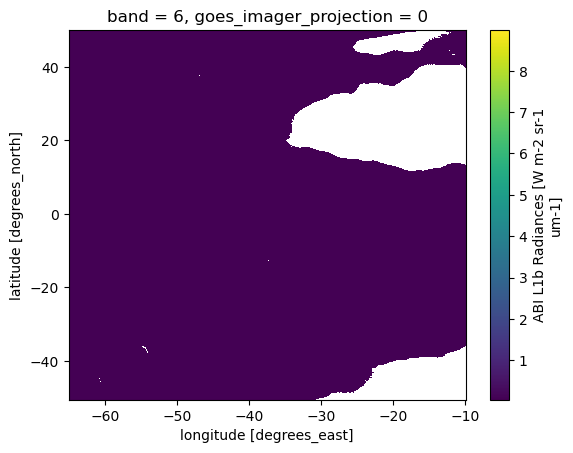

In [46]:
goes_water.isel(band=msg_band).plot()